In [1]:
# This notebook is used for testing learning using the sirasi module.

# In particular, extracting the eigenvectors of the input correlation matrix.
# The algorithm used is based on Foldiak (1989) "Adaptive network for optimal linear feature extraction"
# Proc IEEE/INNS IJCNN 1:401-405
# But other variations are possible

# By Sergio Verduzco Flores        June 2017

In [2]:
from sirasi import *
import numpy as np
import pylab
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

def plot_stuff(data):
    #fig.clf()
    #plt.close()
    fig = plt.figure(figsize=(10,6))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        ax.clear()
        plt.ylim(-0.01,0.5)
        ax.plot(data[0], data[1][i], 'r', figure=fig)
    new_fig = plt.figure(figsize=(5,3))
    plt.plot(sim_dat[0], sim_dat[1][9], 'b', sim_dat[0], sim_dat[1][10], 'k', figure=new_fig)
    plt.plot(sim_dat[0], sim_dat[1][11], 'g', sim_dat[0], sim_dat[1][12], 'r', figure=new_fig)
    fig.canvas.draw()
    plt.show()
    

In [4]:
################# TEST 1 ####################
######### 1) Create a network
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4, 'rtol':1e-5, 'atol':1e-5 } # parameter dictionary for the network
n1 = network(net_params)

######### 2) Put some units in the network
# parameters for the units
n_units = 8
init_val_list = np.random.uniform(0.2, 0.6, n_units) # initial values for the non-source units
slope_list = np.random.uniform(5.0, 7.0 ,n_units) # slopes for sigmoidal units
thresh_list = np.random.uniform(0.0, 0.2, n_units)  #thresholds for sigmoidal units
tau_list = np.random.uniform(2.0, 3.5, n_units)
pars = { 'init_val' : 0.5, 'tau_fast' : 1., 
         'type' : unit_types.source }  
inputs = n1.create(9,pars) # creating nine input sources
pars = { 'coordinates' : [(0.,0.)]*n_units,
         'init_val' : init_val_list, 'tau_fast' : 3., 'tau_slow' : 30.,
         'slope' : slope_list, 'thresh' : thresh_list, 'tau' : tau_list,
         'type' : unit_types.sigmoidal } 
units = n1.create(n_units,pars) # creating sigmoidal units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 
             'delay' : {'distribution' : 'uniform', 'low' : 0.1, 'high' : 0.3},
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : {'distribution':'uniform', 'low':0.3, 'high':0.9}, 
            'lrate' : 0.02, 'type' : synapse_types.hebbsnorm} # synapse parameters dictionary
n1.connect(inputs, units, conn_spec, syn_pars)

# We put competitive learning in the units to see if they can learn to extract different features
syn_pars['init_w'] = 0.
syn_pars['lrate'] = 0.015
syn_pars['type'] = synapse_types.anticov
n1.connect(units, units, conn_spec, syn_pars)

# For hebbsnorm synapses, the sum of synaptic inputs shouldn't change
inp_sums = [sum([syn.w for syn in n1.syns[id][0:9]]) for id in range(9,9+n_units)]
print("Before sim, input sums is:")
print(inp_sums)

######### 4) Running and visualizing 

####### SETTING THE INPUT FUNCTIONS
### You are going to present 4 input patterns that randomly switch over time.
### Imagine the 9 inputs arranged in a grid, like a tic-tac-toe board, numbered
### from left to right and from top to bottom:
### 1 2 3
### 4 5 6
### 7 8 9
### You'll have input patterns
### 0 X 0   0 0 0   X 0 X   0 X 0
### 0 X 0   X X X   0 0 0   X 0 X
### 0 X 0   0 0 0   X 0 X   0 X 0
### The input is always a normalized linear combination of one or two of these patterns.
### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
### 
# here are the patterns as arrays
patterns = [np.zeros(9) for i in range(4)]
patterns[0] = np.array([0., 1., 0., 0., 1., 0., 0., 1., 0.])/3.
patterns[1] = np.array([0., 0., 0., 1., 1., 1., 0., 0., 0.])/3.
patterns[2] = np.array([1., 0., 1., 0., 0., 0., 1., 0., 1.])/4.
patterns[3] = np.array([0., 1., 0., 1., 0., 1., 0., 1., 0.])/4.

n_pres = 40
# number of times some pattern will be presented
t_pat = 12. # as above
t_trans = 4.
c = 1/t_trans # auxiliary variable
pats = range(4) # auxiliary variable
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0.
start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    #plot_stuff(sim_dat)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = np.random.choice(pats)
    
    if pres%10 == 0:
        print('Presentation ' + str(pres+1))

print('Execution time: %s seconds' % (time.time() - start_time))

# For hebbsnorm synapses, the sum of synaptic inputs shouldn't change
inp_sums = [sum([syn.w for syn in n1.syns[id][0:9]]) for id in range(9,9+n_units)]
print("After sim, input sums is:")
print(inp_sums)

Before sim, input sums is:
[5.7864195844945714, 5.9991480469648781, 5.1257110512380066, 5.0792796878795103, 5.7893584064040962, 6.688292015509699, 5.511969334345725, 5.1122557119586123]
Presentation 1
Presentation 11
Presentation 21
Presentation 31
Execution time: 106.68148303031921 seconds
After sim, input sums is:
[5.7864195844945616, 5.9991480469648772, 5.1257110512379933, 5.0792796878795059, 5.789629311248774, 6.6882920155096892, 5.5119693343457179, 5.1124942922326069]


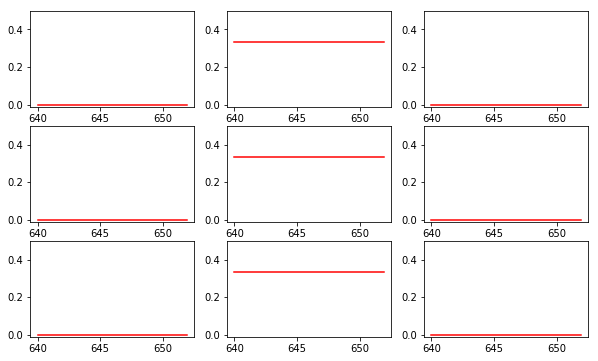

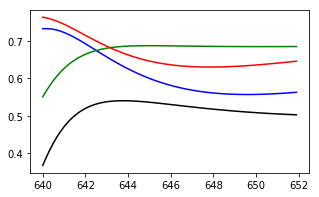

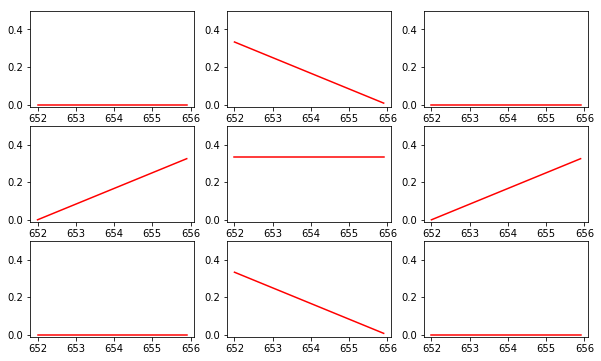

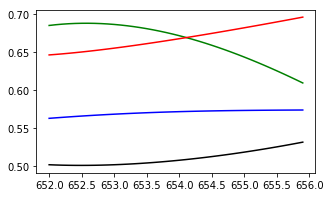

Presentation 1


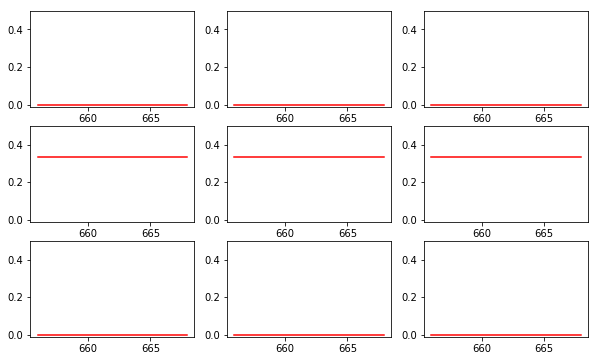

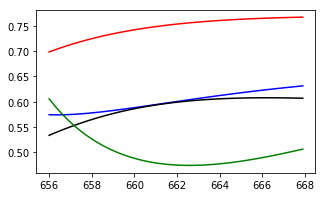

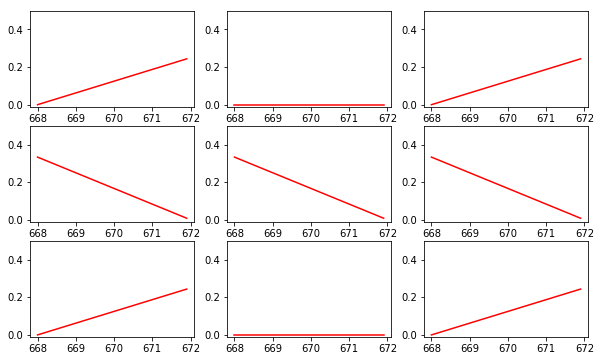

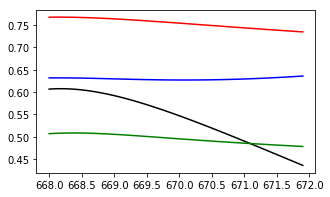

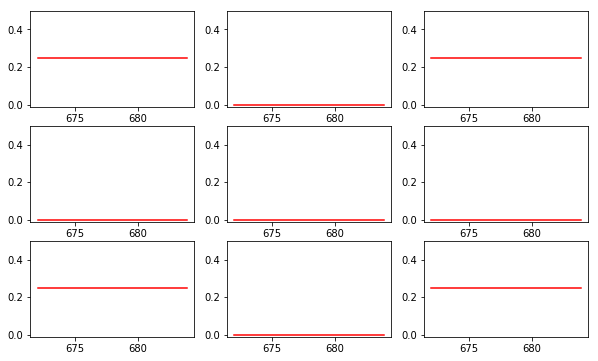

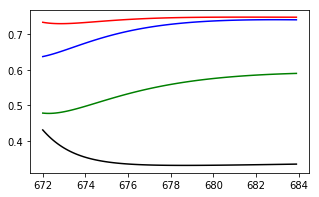

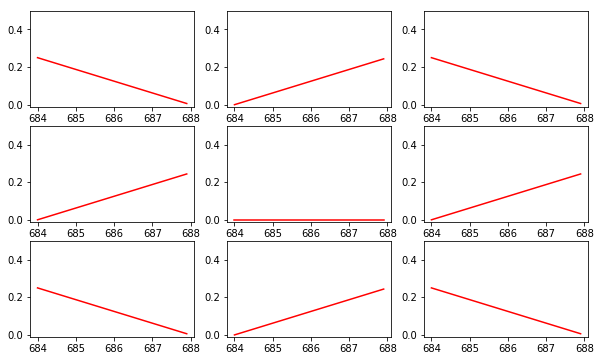

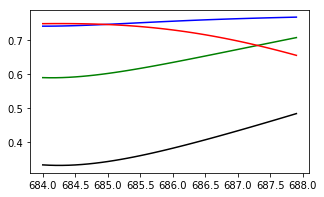

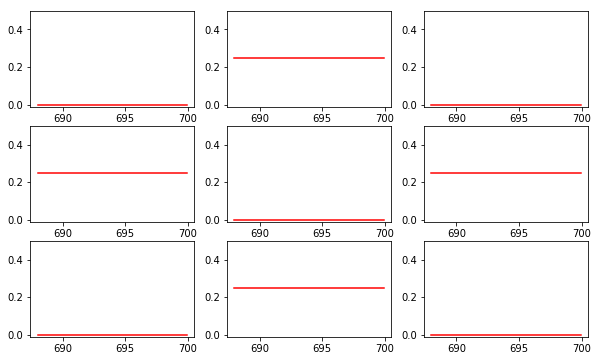

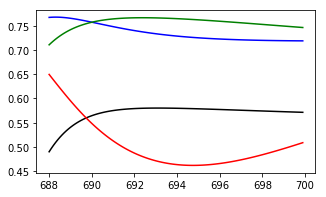

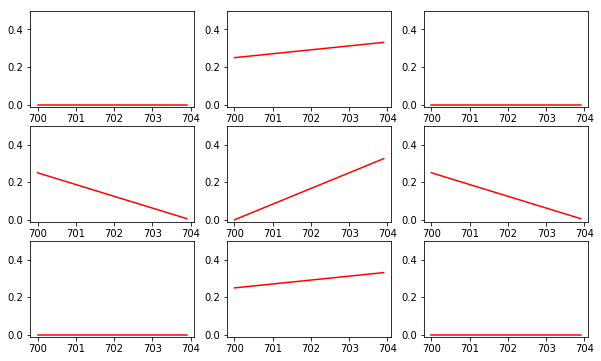

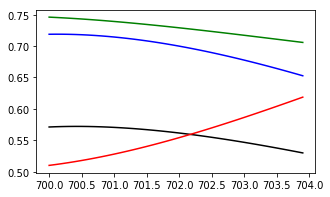

['0.64', '0.65', '0.57', '0.78']
['0.83', '0.93', '0.37', '0.93']
['0.73', '0.59', '0.39', '0.78']
['0.58', '0.68', '0.55', '0.49']
['1.11', '1.07', '0.13', '1.00']
['0.86', '1.10', '0.45', '0.98']
['0.89', '0.85', '0.24', '0.97']
['0.94', '0.89', '0.14', '0.92']


In [5]:
# Checking whether the units have preferred patterns

n_pres = 4
cur_pat = 0
next_pat = 1
for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    
    # first, we present a single pattern
    
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    plot_stuff(sim_dat)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    plot_stuff(sim_dat)
    #input('Transitioned to pattern: ' + str(next_pat))

    # choose the pattern you'll present next
    cur_pat = next_pat
    next_pat = (next_pat+1)%4
    
    if pres%10 == 0:
        print('Presentation ' + str(pres+1))
        
        
weights = [ (np.array(n1.units[9+i].get_weights(n1.sim_time)))[0:9] for i in range(n_units)]
proj = [[] for i in range(n_units)]
for i in range(n_units):
    proj[i] = [sum(weights[i]*patterns[j]) for j in range(4)]
    print(["%.2f" % v for v in proj[i]])



Max eigenvalue: 0.602188329871, index: 2
['0.66', '0.60', '0.65', '0.59', '0.38', '0.97', '0.51', '0.95', '0.47']
['0.55', '0.77', '0.39', '1.00', '0.78', '1.02', '0.29', '0.95', '0.25']
['0.43', '0.76', '0.24', '0.69', '0.43', '0.67', '0.34', '1.01', '0.57']
['0.73', '0.51', '0.44', '0.61', '0.90', '0.52', '0.73', '0.33', '0.31']
['0.00', '1.07', '0.05', '0.80', '1.27', '1.15', '0.26', '0.98', '0.21']
['0.51', '0.83', '0.45', '1.16', '0.98', '1.17', '0.23', '0.76', '0.61']
['0.35', '0.86', '0.39', '0.95', '0.67', '0.94', '0.10', '1.14', '0.11']
['0.46', '1.04', '0.00', '0.78', '0.90', '0.99', '0.00', '0.87', '0.09']


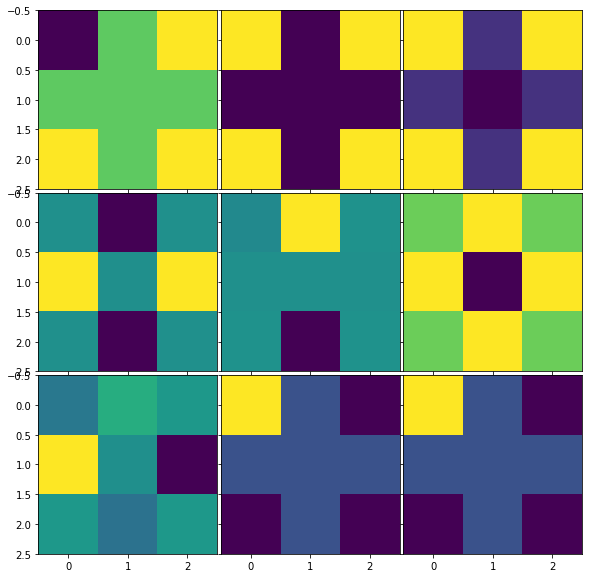

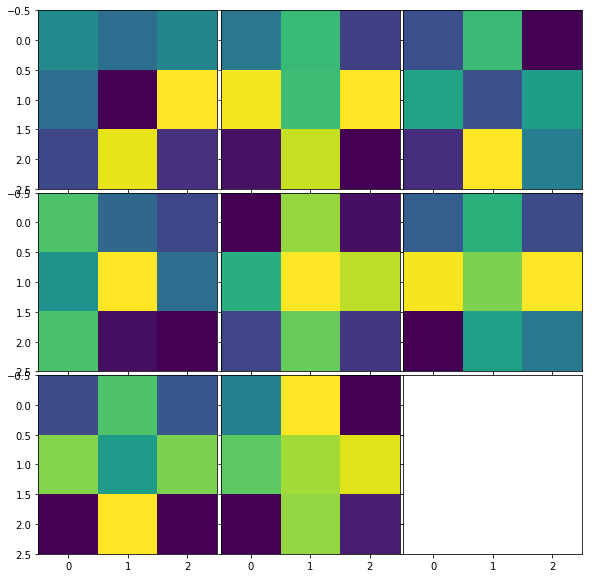

In [6]:
#### Comparing the weight vectors with the leading eigenvector of the correlation matrix
#######################################################################################

plt.ion()

# Obtaining eigenvectors of the correlation matrix
pat_mat = np.matrix(patterns)
corr = (pat_mat.T)*pat_mat # input correlation matrix
eigs = np.linalg.eig(corr) # extracting eigenvalues and eigenvectors
evals = eigs[0] # eigenvalues
evecs = [eigs[1][:,i] for i in range(9)] # eigenvectors

# obtaining the leading eigenvector
max_index, max_value = max(enumerate(evals), key=lambda p:p[1])
print('Max eigenvalue: ' + str(max_value) + ', index: ' + str(max_index))
max_evector = evecs[max_index]
    
# plotting all eigenvectors in 3x3 format
fig3 = plt.figure(figsize=(10,10))
ev_grid = ImageGrid(fig3, 111, nrows_ncols=(3,3), axes_pad=0.05)
for idx,vec in enumerate(evecs):
    vec.shape = 3,3
    ev_grid[idx].imshow(vec)

# plotting leading eigenvector VS weight vectors in 3x3 format
fig4 = plt.figure(figsize=(10,10))
cols = int(round(np.sqrt(n_units)))
if cols*cols < n_units:
    rows = cols + 1
else:
    rows = cols
sp_ev_grid = ImageGrid(fig4, 111, nrows_ncols=(rows,cols), axes_pad=0.05)
for idx,vec in enumerate(weights):
    vec.shape = 3,3
    sp_ev_grid[idx].imshow(vec)
    print(["%.2f" % float(v[0]) for v in vec.reshape(9,1)])


['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0

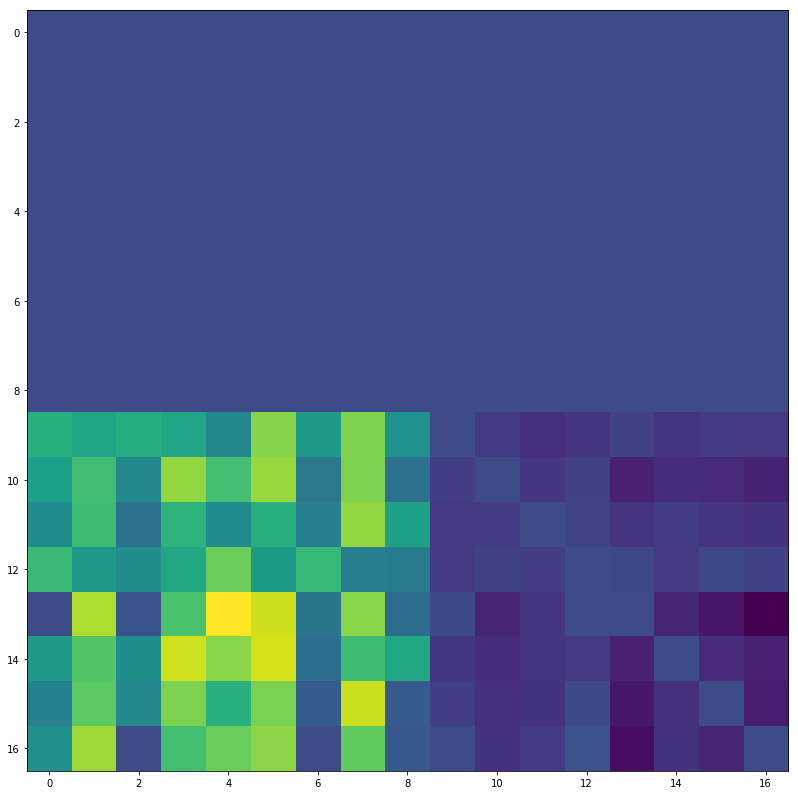

In [7]:
C = conn_mat(n1)
for row in C:
    print(["{0:0.1f}".format(i) for i in row])

fig5 = plt.figure(figsize=(14,14))
conn_grid = ImageGrid(fig5, 111, nrows_ncols=(1,1), axes_pad=0.2)
conn_grid[0].imshow(C)
#print(n1.delays)

In [8]:
for unit in n1.units:
    if unit.type == unit_types.sigmoidal:
        print('delay: %f' % unit.delay)
        print('init: %f' % unit.init_val)
        print('tau: %f' % unit.tau)
        print('thresh: %f' % unit.thresh)
        print('slope: %f' % unit.slope)
        print('')
        

delay: 0.400000
init: 0.279948
tau: 3.474897
thresh: 0.133207
slope: 6.234032

delay: 0.400000
init: 0.204035
tau: 3.345151
thresh: 0.176573
slope: 5.104471

delay: 0.400000
init: 0.402268
tau: 3.259384
thresh: 0.162157
slope: 6.432447

delay: 0.400000
init: 0.310164
tau: 3.235142
thresh: 0.120594
slope: 6.223272

delay: 0.400000
init: 0.258682
tau: 3.328748
thresh: 0.085347
slope: 6.843581

delay: 0.400000
init: 0.323794
tau: 2.503883
thresh: 0.043519
slope: 6.523256

delay: 0.400000
init: 0.236281
tau: 2.153892
thresh: 0.153564
slope: 5.314241

delay: 0.400000
init: 0.572659
tau: 2.738256
thresh: 0.102237
slope: 6.646963



In [9]:
weights

[array([[ 0.66393619,  0.59604208,  0.65307329],
        [ 0.59182126,  0.38099697,  0.97370106],
        [ 0.5092723 ,  0.95226623,  0.46531021]]),
 array([[ 0.55432269,  0.76569685,  0.39311796],
        [ 1.00272053,  0.77978263,  1.01684739],
        [ 0.2872805 ,  0.95072245,  0.24865705]]),
 array([[ 0.42699872,  0.76206289,  0.23833294],
        [ 0.68773868,  0.42808308,  0.66672909],
        [ 0.33857598,  1.00772647,  0.56946319]]),
 array([[ 0.73436618,  0.507807  ,  0.43692042],
        [ 0.60853311,  0.89742937,  0.52328822],
        [ 0.72896694,  0.33176832,  0.31020013]]),
 array([[ 0.        ,  1.06937461,  0.05372721],
        [ 0.80201164,  1.27203529,  1.1451704 ],
        [ 0.26362817,  0.97678701,  0.20703882]]),
 array([[ 0.50925904,  0.83105842,  0.44651119],
        [ 1.15541385,  0.98227947,  1.16714224],
        [ 0.22842539,  0.7610029 ,  0.6071995 ]]),
 array([[ 0.35141144,  0.85674435,  0.39006254],
        [ 0.94846849,  0.67334465,  0.93878985],
        

In [10]:
a = np.ones(4)
a[1] = 0
a

array([ 1.,  0.,  1.,  1.])

In [11]:
0 if False else 3

3